In [178]:
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')
%matplotlib notebook

In [156]:
# Import Data

stock_data = pd.read_csv("../data/nyse/prices-split-adjusted.csv")

In [157]:
stock_data["date"] = pd.to_datetime(stock_data["date"])
stock_data.set_index("date",inplace=True)

In [158]:
def get_company_data(data,symbol_col):
    companies = data[symbol_col].unique()
    #data.set_index("date")
    #companies = [x for x in companies if x != "WLTW"]
    df = pd.DataFrame()
    df["date"] = sorted(data.index.unique())
    df.set_index("date",inplace=True)
    for company in companies:
        df[company] = np.nan
        temp = data.loc[data[symbol_col]==company,"close"]
        df.loc[temp.index,company] = temp.values
    return(df)

In [159]:
df = get_company_data(stock_data,"symbol")

In [164]:
total_companies = df.columns
print(df.shape)

(1762, 501)


<IPython.core.display.Javascript object>


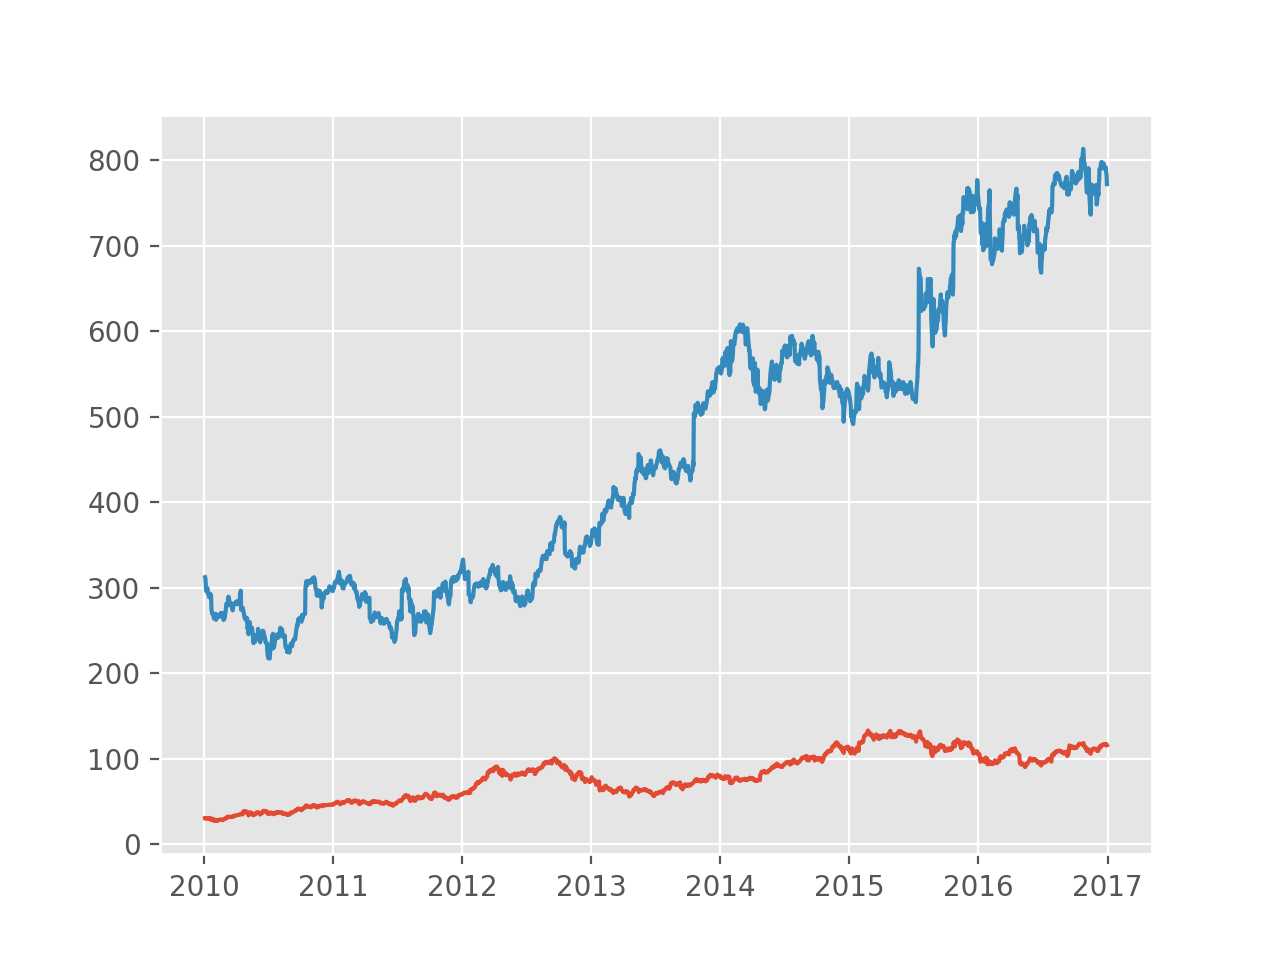

In [161]:
plt.plot(df.index,df["AAPL"])
plt.plot(df.index,df["GOOG"])
plt.show()

In [196]:
def get_lagged_data(df,days,company):
    df = df.dropna(0)
    for day in range(1,days+1):
        df["{}_{}d".format(company,day)] =(df[company].shift(-day) - df[company])/df[company]
    df = df.dropna(0)
    return(df)
        
def get_labels(*args):
    cols = [c for c in args]
    req = 0.015
    for col in cols:
        if col > req:
            return 1
        if col < -req:
            return -1
    return 0

def create_vars(df,company):
    # setup
    
    days_back = 10
    
    ml_data = get_lagged_data(df,days_back,company)

    ml_data["{}_target".format(company)] = list(map(get_labels,
                                                    ml_data["{}_1d".format(company)].values,
                                                    ml_data["{}_2d".format(company)].values,
                                                    ml_data["{}_3d".format(company)].values,
                                                    ml_data["{}_4d".format(company)].values,
                                                    ml_data["{}_5d".format(company)].values,
                                                    ml_data["{}_6d".format(company)].values,
                                                    ml_data["{}_7d".format(company)].values,
                                                    ml_data["{}_8d".format(company)].values,
                                                    ml_data["{}_9d".format(company)].values,
                                                    ml_data["{}_10d".format(company)].values
                                                   ))
    
    return(ml_data)

def get_x_and_y(df,company,split):
    column_names = [col for col in df.columns if company in col]
    x = pd.DataFrame(df.loc[:,total_companies].pct_change())
    x = x.replace([np.inf,-np.inf],np.nan)
    x = x.fillna(0)
    
    y = df["{}_target".format(company)]
    
    print("Total size of x: ",x.shape)
    print("Total size of y: ",y.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=split)

    return(x_train,x_test,y_train,y_test)


def run_ml(df,company):
    
    print("Status: function started")
    print("\tData has a shape of {},{}".format(df.shape[0],df.shape[1]))
    
    df.fillna(0,inplace=True)
    
    df = create_vars(df,company)
    
    print("Status: prepping ML")
    print("\tData has a shape of {},{}".format(df.shape[0],df.shape[1]))
    
    x_train,x_test,y_train,y_test = get_x_and_y(df,company,0.3)
    
    print("Status: training and test data prepped")
    print("training: {}\t test: {}".format(x_train.shape,x_test.shape))
    
    clf = neighbors.KNeighborsClassifier()
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_train)
    confidence = clf.score(x_test,y_test)
    
    print("Confidence: ",confidence)
    
    print(Counter(y_pred))
    print(Counter(y_train))
    
    conf_mat = confusion_matrix(y_train,y_pred)
    
    return(clf)
    

In [106]:
#ml_data = create_ml_data(df,"AAPL")

/Users/jakubkasan/coding/data-science/nyse/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [131]:
#x,y = get_final_model(ml_data,"AAPL")

In [197]:
knn_clf = run_ml(df,"AAPL")

Status: function started
	Data has a shape of 1762,501
Status: prepping ML
	Data has a shape of 1752,512
Total size of x:  (1752, 501)
Total size of y:  (1752,)
Status: training and test data prepped
training: (1226, 501)	 test: (526, 501)
Confidence:  0.5228136882129277
Counter({-1: 791, 1: 432, 0: 3})
Counter({1: 644, -1: 552, 0: 30})


In [173]:
y_pred

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0])